Tutorial
===

In this tutorial we'll explore the two main pieces of functionality that
`HSMMLearn` provides:

- Viterbi decoding: given a sequence of observations, find the sequence of
  hidden states that maximizes the joint probability of the observations and
  the states.
- Baum-Welch model inference: given a sequence of observations, find the model
  parameters (the transition and emission matrices, and the duration
  distributions) that maximize the probability of the observations given the
  model.

In case you are reading this as part of the Sphinx documentation, there is an IPython 4 notebook with the contents of this tutorial in the `notebooks/` folder at the root of the repository.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

Decoding
---

For this part of the tutorial we'll use an HSMM with 3 internal states and 4 durations 1, ..., 4. We'll stick to using Gaussian emissions throughout (i.e. the probability density of the observations given the state is a 1D Gaussian with a fixed mean and standard deviation), but discrete observations (or observations modeled on another class of PDF) can be slotted in equally easily.

The transition matrix is chosen so that there are no self-transitions (all the diagonal elements are 0). This forces the system to go to a different state at the end of each duration. This is not strictly necessary, but allows us to visualize the effect of the different durations a little better. 

The duration matrix is chosen so that for state 1, there is a 90% chance of having the duration equal to 4, and 10% duration 1. For state 2 and 3, there is a 90% probability of having duration 3, resp. 2. As the duration lengths don't differ much, this won't be very visible, but for sparse duration distributions with many durations it does make a difference.

For the emission PDFs, we choose clearly separated Gaussians, with means 0, 5, and 10, and standard deviation equal to 1 in each case.

In [3]:
from hsmmlearn.hsmm import GaussianHSMM

durations = np.array([
    [0.1, 0.0, 0.0, 0.9],
    [0.1, 0.0, 0.9, 0.0],
    [0.1, 0.9, 0.0, 0.0]
])
tmat = np.array([
    [0.0, 0.5, 0.5],
    [0.3, 0.0, 0.7],
    [0.6, 0.4, 0.0]
])

means = np.array([0.0, 5.0, 10.0])
scales = np.ones_like(means)

hsmm = GaussianHSMM(
    means, scales, durations, tmat,
)

Having initialized the Gaussian HSMM, let's sample from it to obtain a sequence of internal states and observations:

In [4]:
observations, states = hsmm.sample(300)

In [5]:
print(states[:20])

[2 2 1 1 1 2 2 0 0 0 0 2 2 1 1 1 2 2 1 1]


In [6]:
print(observations[:20])

[ 10.52314041   9.86235128   4.07406132   5.44132853   5.76402099
  11.43504019  10.13734856  -0.93207824   0.75532059  -1.29944693
  -0.47906227   9.9658948   10.36830046   3.4782257    4.58492773
   5.10710389   8.49856484  11.92186325   5.41462254   3.9717193 ]


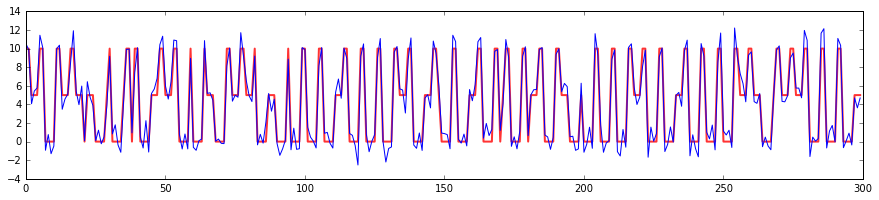

In [7]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(means[states], 'r', linewidth=2, alpha=.8)
ax.plot(observations)

In the figure, the red line is the mean of the PDF that was selected for that internal state, and the blue line shows the observations. As is expected, the observations are clustered around the mean for each state.

Assuming now that we only have the observations, and we want to reconstruct, or decode, the most likely internal states for those observations. This can be done by means of the classical Viterbi algorithm, which has an extension for HSMMs.

In [8]:
decoded_states = hsmm.decode(observations)

Given that our Gaussian peaks are so clearly separated, the Viterbi decoder manages to reconstruct the entire state sequence correctly. No surprise, and not very exciting.

In [9]:
np.sum(states != decoded_states)  # Number of differences between the original and the decoded states

0

Things become a little more interesting when the peaks are not so well separated. In the example below, we move the mean of the second Gaussian up to 8.0 (up from 5.0), and then we sample and decode again. We also set the duration distribution to something a little more uniform, just to make things harder on the decoder (it turns out that otherwise the decoder is able to infer the internal state sequence almost completely on the basis of the inferred durations alone).

In [10]:
new_means = np.array([0.0, 8.0, 10.0])

hsmm.durations = np.full((3, 4), 0.25)
hsmm.means = new_means

observations, states = hsmm.sample(200)
decoded_states = hsmm.decode(observations)

In [11]:
np.sum(states != decoded_states)

10

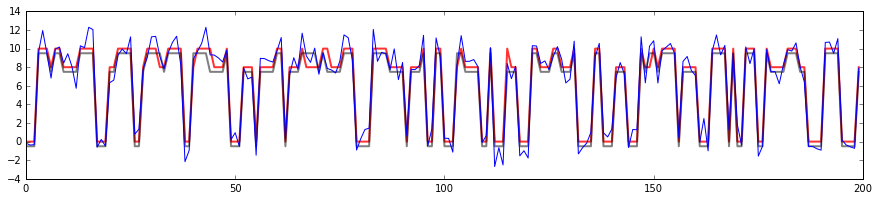

In [12]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(new_means[states], 'r', linewidth=2, alpha=.8)
ax.plot(new_means[decoded_states] - 0.5, 'k', linewidth=2, alpha=.5)
ax.plot(observations)

In the figure, the red line again shows the mean of the original sequence of internal states, while the gray line (offset by 0.5 to avoid overlapping with the rest of the plot) shows the reconstructed sequence. They track each other pretty faithfully, except in areas where the observations give not much information about the internal state.

Aside: different emission PDFs
---

In the previous example, we worked throughout with an instance of the class `GaussianHSMM`. This is a convenience wrapper around a more general class `hsmmlearn.hsmm.HSMMModel`, which allows for more general emission PDFs via Python descriptors. To see how this works, let's first re-instantiate our Gaussian HSMM via `HSMMModel`:

In [13]:
from hsmmlearn.hsmm import HSMMModel
from hsmmlearn.emissions import GaussianEmissions

gaussian_hsmm = HSMMModel(
    GaussianEmissions(means, scales), durations, tmat
)

This class can be used in much the same way as the more practical `GaussianHSMM`. However, it lacks some convenience attributes (`.means`, `.scales`, ...) that `GaussianHSMM` does have.

To create an HSMM with a different class of emission PDFs, it suffices to derive from `hsmmlearn.emissions.AbstractEmissions` and supply the required functionality there. This is an abstract base class with a couple of abstract methods that need to be overridden in the concrete class. If you require only some of the functionality, you can override the methods that you don't need with an empty function. To see this in practice, let's create an HSMM with Laplace emission PDFs. Below, we override `sample_for_state` because we want to sample from the HSMM, and `likelihood`, needed to run Viterbi (not demonstrated).

In [14]:
from scipy.stats import laplace

from hsmmlearn.emissions import AbstractEmissions

# Note: this is almost identical to the GaussianEmissions class,
# the only difference being that we replaced the Gaussian RV (norm)
# with a Laplacian RV (laplace).
class LaplaceEmissions(AbstractEmissions):

    # Note: this property is a hack, and will become unnecessary soon!
    dtype = np.float64
        
    def __init__(self, means, scales):
        self.means = means
        self.scales = scales

    def likelihood(self, obs):
        obs = np.squeeze(obs)
        # TODO: build in some check for the shape of the likelihoods, otherwise
        # this will silently fail and give the wrong results.
        return laplace.pdf(obs,
                           loc=self.means[:, np.newaxis],
                           scale=self.scales[:, np.newaxis])

    def sample_for_state(self, state, size=None):
        return laplace.rvs(self.means[state], self.scales[state], size)

In [15]:
laplace_hsmm = HSMMModel(
    LaplaceEmissions(means, scales), durations, tmat
)

In [16]:
observations, states = laplace_hsmm.sample(10000)

Let's check that this defines indeed an HSMM with Laplacian output PDFs:

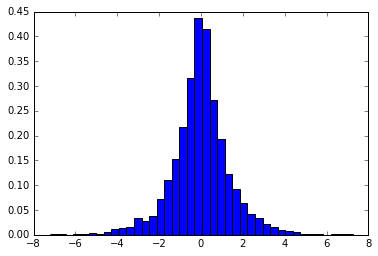

In [17]:
state0_mask = states == 0
observations_state0 = observations[state0_mask]

fig, ax = plt.subplots()
_ = ax.hist(observations_state0, bins=40, normed=True)

Looks indeed like a Laplacian distribution!

Model inference
--

In the next section, we'll tackle the "third question" outlined by Rabiner: given a sequence of observed data, what is the "most likely" model that could have given rise to these observations? To achieve this, we'll employ an iterative procedure known as the expectation maximization algorithm, which adjusts the transition/emission/duration data to generate the optimal model.

We start by sampling from a Gaussian HSMM that has three states, with very clearly separated durations.

In [18]:
from hsmmlearn.hsmm import GaussianHSMM

durations = np.zeros((3, 10)) # XXXX
durations[:, :] = 0.05
durations[0, 1] = durations[1, 5] = durations[2, 9] = 0.55

tmat = np.array([
    [0.0, 0.5, 0.5],
    [0.3, 0.0, 0.7],
    [0.6, 0.4, 0.0]
])

means = np.array([0.0, 5.0, 10.0])
scales = np.ones_like(means)

hsmm = GaussianHSMM(
    means, scales, durations, tmat,
)

In [19]:
hsmm.durations

array([[ 0.05,  0.55,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,
         0.05],
       [ 0.05,  0.05,  0.05,  0.05,  0.05,  0.55,  0.05,  0.05,  0.05,
         0.05],
       [ 0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,  0.05,
         0.55]])

In [20]:
observations, states = hsmm.sample(200)

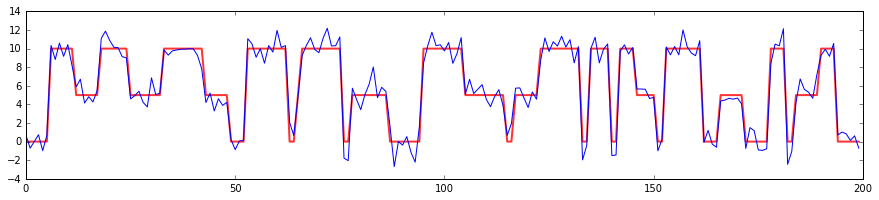

In [21]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(means[states], 'r', linewidth=2, alpha=.8)
ax.plot(observations)

The plot shows clearly that the durations are separated: state 0, with mean 0.0, has very short durations, while states 1 and 2 have much longer durations.

Having sampled from the HSMM, we'll now forget our duration distribution and set up a new HSMM with a flat duration distribution.

In [22]:
equal_prob_durations = np.full((3, 10), 0.1)
new_hsmm = GaussianHSMM(
    means, scales, equal_prob_durations, tmat,
)

In [23]:
equal_prob_durations

array([[ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1]])

Using the `.fit` method, we'll run the expectation-maximization algorithm on our new duration-agnostic HSMM. This will adjust the parameters of the HSMM in place, to best match the given observations.

In [24]:
# Fit returns a bool to indicate whether the EM algorithm converged,
# and the log-likelihood after the adjustments are made.
new_hsmm.fit(observations)

(True, -352.16412850351435)

If we examine the adjusted duration distribution, we see that this reproduces to some extent the original distribution, with very pronounced probabilities for duration 2 in state 0, duration 6 in state 1, and duration 10 in state 2.

In [25]:
np.set_printoptions(precision=1)
print new_hsmm.durations
np.set_printoptions()

[[  7.1e-35   5.4e-01   1.2e-31   1.5e-01   4.4e-39   2.1e-01   7.2e-08
    1.0e-01   5.9e-08   5.9e-08]
 [  1.0e-01   5.5e-49   3.1e-49   3.2e-51   1.0e-01   5.0e-01   1.2e-18
    1.0e-01   1.0e-01   1.0e-01]
 [  3.7e-44   9.0e-56   5.8e-41   2.5e-01   8.4e-02   8.3e-02   8.3e-02
    3.8e-57   8.3e-02   4.2e-01]]


In tandem with the duration distributions, the other parameters have also changed. The transition matrix has become a little more pronounced to emphasize the transitions between different states, and the locations and scales of the emission PDFs have shifted a bit.

In [26]:
np.set_printoptions(precision=1)
print 'New transition matrices:'
print new_hsmm.tmat
print 'New emission parameters:'
print 'Means:', new_hsmm.means
print 'Scales:', new_hsmm.scales
np.set_printoptions()

New transition matrices:
[[ 0.   0.4  0.6]
 [ 0.5  0.   0.5]
 [ 0.6  0.4  0. ]]
New emission parameters:
Means: [ -0.2   5.1  10.1]
Scales: [ 1.2  0.9  0.9]
